# Rotman MMA Summer 2023 Datathon 

**Topic**: NWHL

**Group**: Purple

**Group member**: Yanbing (Violet) Chen, Yuan Feng, Pranav Khurana, Shubham Kushwaha

## I. The question we choose: 
The coaches would like to select five top players. The players should, ideally, excel in all areas ofthe game. Since scoring goals is the ultimate objective, at least three should be excellent goal scorers and at least two should be excellent passers. In addition, you need at least two faceoff specialists and one takeaway specialist. It would be especially beneficial if the passers were familiar with the shooting specialists (i.e., had a good track record of completing passes to these players).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib auto
import seaborn as sns
import itertools
from sklearn.preprocessing import MinMaxScaler
from pulp import *
import random
from itertools import combinations
from deap import base, creator, tools, algorithms
import os
from sklearn.cluster import *
from collections import Counter
import math
from sklearn.decomposition import *

##  II. Data Cleanning and Processing (SPV)

**Statement** : The **`Sum Passed Version`** does **not** take into account which player each player has passed and the number of successes corresponding to them. We use this cleaned data version to culculate evaluation score for each player.

In [2]:
# read data
df = pd.read_csv("Rotman MMA Summer Datathon NWHL.csv")
df['game_date'] = pd.to_datetime(df['game_date'])
df.head()

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,...,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2
0,2021-01-23,Minnesota Whitecaps,Boston Pride,1,20:00,5,5,0,0,Boston Pride,...,Faceoff Win,100,43,Backhand,NaN,NaN,NaN,Stephanie Anderson,NaN,NaN
1,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:58,5,5,0,0,Boston Pride,...,Puck Recovery,107,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:57,5,5,0,0,Boston Pride,...,Zone Entry,125,28,Carried,NaN,NaN,NaN,Maddie Rowe,NaN,NaN
3,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:55,5,5,0,0,Boston Pride,...,Shot,131,28,Snapshot,On Net,t,f,NaN,NaN,NaN
4,2021-01-23,Minnesota Whitecaps,Boston Pride,1,19:53,5,5,0,0,Boston Pride,...,Faceoff Win,169,21,Backhand,NaN,NaN,NaN,Stephanie Anderson,NaN,NaN


#### Get all Player name at first

In [3]:
df_name = pd.DataFrame(df.groupby(["Player"])["game_date"].count())
df_name.reset_index(inplace=True)
df_name = df_name[["Player"]]
df_name

,Player
0,Abbie Ives
1,Allie Olnowich
2,Allie Thunstrom
3,Alyson Matteau
4,Alyssa Wohlfeiler
...,...
121,Tori Howran
122,Tori Sullivan
123,Victoria Hanson
124,Whitney Dove


#### Shot & Goal

In [4]:
# df.info()
event_type_counts= df['Event'].value_counts()
event_type_counts

Puck Recovery      8214
Play               7249
Incomplete Play    3430
Zone Entry         1944
Shot               1909
Dump In/Out        1863
Takeaway           1207
Faceoff Win         846
Penalty Taken       144
Goal                 76
Name: Event, dtype: int64

In [5]:
df_goal_shot = df[df["Event"].isin(["Shot","Goal"])]
df_goal_shot.reset_index(inplace=True,drop=True)
df_goal_shot_grouped = pd.DataFrame(df_goal_shot.groupby(["Player","Event","Team"])["game_date"].count())
df_goal_shot_grouped.reset_index(inplace=True)
df_goal_shot_grouped.sort_values(by=["game_date"],inplace=True,ascending=False)
df_goal_shot_grouped.columns = ["Player","Event","Team","Count"]
df_goal_shot_grouped.head()

,Player,Event,Team,Count
100,McKenna Brand,Shot,Boston Pride,55
112,Mikyla Grant-Mentis,Shot,Toronto Six,49
74,Lauren Kelly,Shot,Boston Pride,42
146,Taylor Woods,Shot,Toronto Six,42
133,Sarah-Eve Coutu Godbout,Shot,Toronto Six,42


In [6]:
df_goal = df_goal_shot_grouped[df_goal_shot_grouped["Event"]=="Goal"]
df_shot = df_goal_shot_grouped[df_goal_shot_grouped["Event"]=="Shot"]

In [7]:
df_joined = df_shot.merge(df_goal,on="Player")
df_joined.columns=["Player","Shot","Team","# Shots","Goal","Team","# Goals"]
df_goal_shots = df_joined[["Player","Team", "# Shots","# Goals"]]

# Calculate the Scoring rate
df_goal_shots["Scoring Rate(%)"] = (df_goal_shots["# Goals"]/df_goal_shots["# Shots"])*100
df_goal_shots = pd.merge(df_name, df_goal_shots, left_on=["Player"], right_on=["Player"], how = 'left')
df_goal_shots.fillna(value = 0, inplace = True)
df_goal_shots

C:\Users\Yuan\AppData\Local\Temp\ipykernel_18288\36953677.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_goal_shots["Scoring Rate(%)"] = (df_goal_shots["# Goals"]/df_goal_shots["# Shots"])*100


,Player,Team,Team,# Shots,# Goals,Scoring Rate(%)
0,Abbie Ives,0,0,0.0,0.0,0.000000
1,Allie Olnowich,0,0,0.0,0.0,0.000000
2,Allie Thunstrom,0,0,0.0,0.0,0.000000
3,Alyson Matteau,0,0,0.0,0.0,0.000000
4,Alyssa Wohlfeiler,Connecticut Whale,Connecticut Whale,24.0,1.0,4.166667
...,...,...,...,...,...,...
121,Tori Howran,Connecticut Whale,Connecticut Whale,13.0,1.0,7.692308
122,Tori Sullivan,0,0,0.0,0.0,0.000000
123,Victoria Hanson,0,0,0.0,0.0,0.000000
124,Whitney Dove,0,0,0.0,0.0,0.000000


In [8]:
df_goal_shots.sort_values('Scoring Rate(%)', ascending = False).head()

,Player,Team,Team,# Shots,# Goals,Scoring Rate(%)
61,Leila Kilduff,Metropolitan Riveters,Metropolitan Riveters,5.0,2.0,40.000000
18,Cailey Hutchison,Metropolitan Riveters,Metropolitan Riveters,4.0,1.0,25.000000
125,Winny Brodt-Brown,Minnesota Whitecaps,Minnesota Whitecaps,5.0,1.0,20.000000
9,Autumn MacDougall,Buffalo Beauts,Buffalo Beauts,18.0,3.0,16.666667
36,Haley Mack,Minnesota Whitecaps,Minnesota Whitecaps,13.0,2.0,15.384615


#### Play & Inplay

In [9]:
# Play
df_play = df[df["Event"].isin(["Play"])]
df_play.reset_index(inplace=True,drop=True)
df_play_grouped = pd.DataFrame(df_play.groupby(["Player"])["game_date"].count())
df_play_grouped.reset_index(inplace=True)
df_play_grouped.sort_values(by=["game_date"],inplace=True,ascending=False)
df_play_grouped.columns = ["Player","# succesful passes"]
df_play_grouped

,Player,# succesful passes
48,Kaleigh Fratkin,242
76,Mallory Souliotis,175
104,Sarah Steele,158
116,Taylor Woods,157
108,Shiann Darkangelo,154
...,...,...
77,Mariah Fujimagari,3
67,Lynn Astrup,3
73,Maeve Reilly,3
102,Sarah Hughson,2


In [10]:
# Incomplete Play
df_Inplay = df[df["Event"].isin(["Incomplete Play"])]
df_Inplay.reset_index(inplace=True,drop=True)
df_Inplay_grouped = pd.DataFrame(df_Inplay.groupby(["Player"])["game_date"].count())
df_Inplay_grouped.reset_index(inplace=True)
df_Inplay_grouped.sort_values(by=["game_date"],inplace=True,ascending=False)
df_Inplay_grouped.columns = ["Player","# unsuccesful passes"]
df_Inplay_grouped

,Player,# unsuccesful passes
47,Kaleigh Fratkin,90
75,Mallory Souliotis,84
59,Lauren Kelly,77
63,Lindsay Eastwood,70
106,Shiann Darkangelo,63
...,...,...
96,Rose Alleva,2
100,Sarah Hughson,2
76,Mariah Fujimagari,1
17,Brooke Wolejko,1


In [11]:
# Success Play Ratio
df_play_inplay_merged = pd.merge(df_play_grouped, df_Inplay_grouped, left_on=["Player"], right_on=["Player"], how = 'left')
df_play_inplay_merged.fillna(value = 0, inplace = True)
df_play_inplay_merged["Success Pass Rate"] = df_play_inplay_merged["# succesful passes"] / (df_play_inplay_merged["# succesful passes"] + df_play_inplay_merged["# unsuccesful passes"])
df_play_inplay_merged = df_play_inplay_merged.sort_values(by=["# succesful passes", "Success Pass Rate"], ascending=[False, False])
df_play_inplay_merged

,Player,# succesful passes,# unsuccesful passes,Success Pass Rate
0,Kaleigh Fratkin,242,90.0,0.728916
1,Mallory Souliotis,175,84.0,0.675676
2,Sarah Steele,158,55.0,0.741784
3,Taylor Woods,157,46.0,0.773399
4,Shiann Darkangelo,154,63.0,0.709677
...,...,...,...,...
121,Mariah Fujimagari,3,1.0,0.750000
123,Maeve Reilly,3,3.0,0.500000
122,Lynn Astrup,3,5.0,0.375000
124,Sarah Hughson,2,2.0,0.500000


In [12]:
# Merge
df_goals_shots_passes_merged = df_goal_shots.merge(df_play_inplay_merged,left_on="Player",right_on="Player", how = 'left')
df_goals_shots_passes_merged.fillna(value = 0, inplace = True)
df_goals_shots_passes = df_goals_shots_passes_merged[["Player", "# succesful passes", "# unsuccesful passes", "Success Pass Rate", "# Goals","# Shots","Scoring Rate(%)"]]
# df_goals_shots_passes.to_csv("df_shots_goals_passes_merged.csv")
df_goals_shots_passes.sort_values(by = ['Scoring Rate(%)', '# succesful passes'], ascending  = [False, False]).head()
df_goals_shots_passes

,Player,# succesful passes,# unsuccesful passes,Success Pass Rate,# Goals,# Shots,Scoring Rate(%)
0,Abbie Ives,13,3.0,0.812500,0.0,0.0,0.000000
1,Allie Olnowich,23,7.0,0.766667,0.0,0.0,0.000000
2,Allie Thunstrom,45,24.0,0.652174,0.0,0.0,0.000000
3,Alyson Matteau,130,49.0,0.726257,0.0,0.0,0.000000
4,Alyssa Wohlfeiler,87,27.0,0.763158,1.0,24.0,4.166667
...,...,...,...,...,...,...,...
121,Tori Howran,74,35.0,0.678899,1.0,13.0,7.692308
122,Tori Sullivan,86,16.0,0.843137,0.0,0.0,0.000000
123,Victoria Hanson,12,0.0,1.000000,0.0,0.0,0.000000
124,Whitney Dove,105,51.0,0.673077,0.0,0.0,0.000000


#### Faceoff

In [13]:
# Faceoff
df_faceoff = df[df['Event'].isin(['Faceoff Win'])]
df_faceoff.reset_index(inplace=True,drop=True)
df_faceoff_grouped = pd.DataFrame(df_faceoff.groupby(["Player","Team"])["game_date"].count())
df_faceoff_grouped.reset_index(inplace=True)
df_faceoff_grouped.sort_values(by=["game_date"],inplace=True,ascending=False)
df_faceoff_grouped.columns = ["Player","Team","# faceoff wins"]
df_faceoff_grouped.head()


,Player,Team,# faceoff wins
53,Shiann Darkangelo,Toronto Six,79
21,Jillian Dempsey,Boston Pride,70
32,Lexie Laing,Boston Pride,55
59,Tereza Vanisova,Boston Pride,51
23,Jordan Juron,Buffalo Beauts,49


In [14]:
df_shots_goals_passes_faceoff_merged = df_goals_shots_passes.merge(df_faceoff_grouped, left_on= "Player", right_on = 'Player', how = 'left')
df_shots_goals_passes_faceoff_merged.fillna(value = 0, inplace = True)
#df_shots_goals_passes_faceoff_merged.head()
df_shots_goals_passes_faceoff = df_shots_goals_passes_faceoff_merged[["Player", "# succesful passes", "# unsuccesful passes", "Success Pass Rate", "# Goals","# Shots","Scoring Rate(%)", "# faceoff wins"]]
df_shots_goals_passes_faceoff

,Player,# succesful passes,# unsuccesful passes,Success Pass Rate,# Goals,# Shots,Scoring Rate(%),# faceoff wins
0,Abbie Ives,13,3.0,0.812500,0.0,0.0,0.000000,0.0
1,Allie Olnowich,23,7.0,0.766667,0.0,0.0,0.000000,0.0
2,Allie Thunstrom,45,24.0,0.652174,0.0,0.0,0.000000,1.0
3,Alyson Matteau,130,49.0,0.726257,0.0,0.0,0.000000,0.0
4,Alyssa Wohlfeiler,87,27.0,0.763158,1.0,24.0,4.166667,0.0
...,...,...,...,...,...,...,...,...
121,Tori Howran,74,35.0,0.678899,1.0,13.0,7.692308,0.0
122,Tori Sullivan,86,16.0,0.843137,0.0,0.0,0.000000,1.0
123,Victoria Hanson,12,0.0,1.000000,0.0,0.0,0.000000,0.0
124,Whitney Dove,105,51.0,0.673077,0.0,0.0,0.000000,0.0


 #### Takeaway

In [15]:
# Takeaway 
df_takeaway = df[df["Event"].isin(["Takeaway"])]
df_takeaway.reset_index(inplace=True,drop=True)
df_takeaway_grouped = pd.DataFrame(df_takeaway.groupby(["Player","Team"])["game_date"].count())
df_takeaway_grouped.reset_index(inplace=True)
df_takeaway_grouped.sort_values(by=["game_date"],inplace=True,ascending=False)
df_takeaway_grouped.columns = ["Player","Team","# takeaway wins"]
df_takeaway_grouped.head()

,Player,Team,# takeaway wins
21,Dominique Kremer,Buffalo Beauts,29
2,Alyson Matteau,Buffalo Beauts,28
8,Breanne Wilson-Bennett,Toronto Six,25
70,Marie-Jo Pelletier,Buffalo Beauts,24
80,Natalie Marcuzzi,Toronto Six,23


In [16]:
df_shots_goals_passes_faceoff_takeaway_merged = df_shots_goals_passes_faceoff.merge(df_takeaway_grouped, left_on = 'Player', right_on = 'Player', how = 'left')
# df_shots_goals_passes_faceoff_takeaway_merged.head()
df_shots_goals_passes_faceoff_takeaway = df_shots_goals_passes_faceoff_takeaway_merged[["Player", "# succesful passes", "# unsuccesful passes", "Success Pass Rate", "# Goals","# Shots","Scoring Rate(%)", "# faceoff wins", "# takeaway wins"]]
df_shots_goals_passes_faceoff_takeaway

,Player,# succesful passes,# unsuccesful passes,Success Pass Rate,# Goals,# Shots,Scoring Rate(%),# faceoff wins,# takeaway wins
0,Abbie Ives,13,3.0,0.812500,0.0,0.0,0.000000,0.0,NaN
1,Allie Olnowich,23,7.0,0.766667,0.0,0.0,0.000000,0.0,5.0
2,Allie Thunstrom,45,24.0,0.652174,0.0,0.0,0.000000,1.0,14.0
3,Alyson Matteau,130,49.0,0.726257,0.0,0.0,0.000000,0.0,28.0
4,Alyssa Wohlfeiler,87,27.0,0.763158,1.0,24.0,4.166667,0.0,8.0
...,...,...,...,...,...,...,...,...,...
121,Tori Howran,74,35.0,0.678899,1.0,13.0,7.692308,0.0,13.0
122,Tori Sullivan,86,16.0,0.843137,0.0,0.0,0.000000,1.0,14.0
123,Victoria Hanson,12,0.0,1.000000,0.0,0.0,0.000000,0.0,1.0
124,Whitney Dove,105,51.0,0.673077,0.0,0.0,0.000000,0.0,15.0


In [17]:
#df_shots_goals_passes_faceoff_takeaway.to_csv("df_shots_goals_passes_faceoff_takeaway_merged.csv")

#### Penalty

In [18]:
df_pen = df[df["Event"].isin(["Penalty Taken"])]
df_pen.reset_index(inplace=True,drop=True)
df_pen_taken = pd.DataFrame(df_pen.groupby(["Player"])["game_date"].count())
df_pen_taken.reset_index(inplace=True)
df_pen_taken.sort_values(by=["game_date"],inplace=True,ascending=False)
df_pen_taken.columns = ["Player","# penalty take"]

df_pen_drew = pd.DataFrame(df_pen.groupby(["Player 2"])["game_date"].count())
df_pen_drew.reset_index(inplace=True)
df_pen_drew.sort_values(by=["game_date"],inplace=True,ascending=False)
df_pen_drew.columns = ["Player","# penalty give"]

df_pen_grouped = pd.merge(df_pen_taken, df_pen_drew, left_on=["Player"], right_on=["Player"], how = "outer")
df_pen_grouped.fillna(value = 0, inplace = True)
df_pen_grouped

,Player,# penalty take,# penalty give
0,Emma Stauber,5.0,2.0
1,Whitney Dove,5.0,2.0
2,Tereza Vanisova,5.0,2.0
3,Taylor Woods,5.0,2.0
4,Kaleigh Fratkin,5.0,0.0
...,...,...,...
86,Maggie LaGue,0.0,1.0
87,Mary Parker,0.0,1.0
88,Meaghan Pezon,0.0,1.0
89,Meaghan Rickard,0.0,1.0


In [19]:
df_shots_goals_passes_faceoff_takeaway_pen_merged = df_shots_goals_passes_faceoff_takeaway.merge(df_pen_grouped, left_on = 'Player', right_on = 'Player', how = 'left')
# df_shots_goals_passes_faceoff_takeaway_merged.head()
df_shots_goals_passes_faceoff_takeaway_pen_merged.fillna(value = 0, inplace = True)
df_shots_goals_passes_faceoff_takeaway_pen = df_shots_goals_passes_faceoff_takeaway_pen_merged[["Player", "# succesful passes", "# unsuccesful passes", "Success Pass Rate", "# Goals","# Shots","Scoring Rate(%)", "# faceoff wins", "# takeaway wins", "# penalty take", "# penalty give"]]
df_shots_goals_passes_faceoff_takeaway_pen

,Player,# succesful passes,# unsuccesful passes,Success Pass Rate,# Goals,# Shots,Scoring Rate(%),# faceoff wins,# takeaway wins,# penalty take,# penalty give
0,Abbie Ives,13,3.0,0.812500,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,Allie Olnowich,23,7.0,0.766667,0.0,0.0,0.000000,0.0,5.0,0.0,0.0
2,Allie Thunstrom,45,24.0,0.652174,0.0,0.0,0.000000,1.0,14.0,2.0,2.0
3,Alyson Matteau,130,49.0,0.726257,0.0,0.0,0.000000,0.0,28.0,1.0,3.0
4,Alyssa Wohlfeiler,87,27.0,0.763158,1.0,24.0,4.166667,0.0,8.0,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
121,Tori Howran,74,35.0,0.678899,1.0,13.0,7.692308,0.0,13.0,0.0,1.0
122,Tori Sullivan,86,16.0,0.843137,0.0,0.0,0.000000,1.0,14.0,0.0,7.0
123,Victoria Hanson,12,0.0,1.000000,0.0,0.0,0.000000,0.0,1.0,0.0,0.0
124,Whitney Dove,105,51.0,0.673077,0.0,0.0,0.000000,0.0,15.0,5.0,2.0


#### Merge Info

In [20]:
df1 = df_shots_goals_passes_faceoff_takeaway_pen
# create a copy of df1 before normalize for stats
df_stats = df1
#df1 = df1[["# succesful passes", "# unsuccesful passes", "Success Pass Rate", "# Goals","# Shots","Scoring Rate(%)", "# faceoff wins", "# takeaway wins", "# penalty take", "# penalty give"]].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
#df1 = df1.clip(lower = 0.000001, upper = 0.999999)
#df1[['Player']] = df_shots_goals_passes_faceoff_takeaway_pen[['Player']]
df1 = df1[['Player', "# succesful passes", "# unsuccesful passes", "Success Pass Rate", "# Goals","# Shots","Scoring Rate(%)", "# faceoff wins", "# takeaway wins", "# penalty take", "# penalty give"]]
df1.sort_values(by = ['Scoring Rate(%)', 'Success Pass Rate', '# faceoff wins', '# takeaway wins'], ascending = [False, False, False, False])
#df1.to_csv("df_info.csv")

,Player,# succesful passes,# unsuccesful passes,Success Pass Rate,# Goals,# Shots,Scoring Rate(%),# faceoff wins,# takeaway wins,# penalty take,# penalty give
61,Leila Kilduff,47,20.0,0.701493,2.0,5.0,40.000000,0.0,15.0,0.0,0.0
18,Cailey Hutchison,15,13.0,0.535714,1.0,4.0,25.000000,18.0,8.0,1.0,2.0
125,Winny Brodt-Brown,34,20.0,0.629630,1.0,5.0,20.000000,0.0,7.0,2.0,0.0
9,Autumn MacDougall,71,48.0,0.596639,3.0,18.0,16.666667,0.0,7.0,0.0,4.0
36,Haley Mack,62,28.0,0.688889,2.0,13.0,15.384615,6.0,4.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
73,Maeve Reilly,3,3.0,0.500000,0.0,0.0,0.000000,0.0,1.0,0.0,0.0
59,Laurel Hill,14,15.0,0.482759,0.0,0.0,0.000000,0.0,2.0,1.0,0.0
42,Jayne Lewis,10,11.0,0.476190,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
53,Kayla Meneghin,12,17.0,0.413793,0.0,0.0,0.000000,5.0,2.0,4.0,1.0


In [21]:
df1.to_csv('Cleaned data(Sum Passed Version).csv')

* Finally we get the cleaned data for culculating the **`evaluation score`** for each player.

## III.  Data Visualization

In [22]:
df2 = df[df['Event'].isin(['Shot','Goal','Play','Faceoff Win','Takeaway'])][['Event','Player','Team']]
df2.reset_index(inplace = True, drop = True)
# df2

Text(0.5, 1.0, 'Number of Events in Each Team')

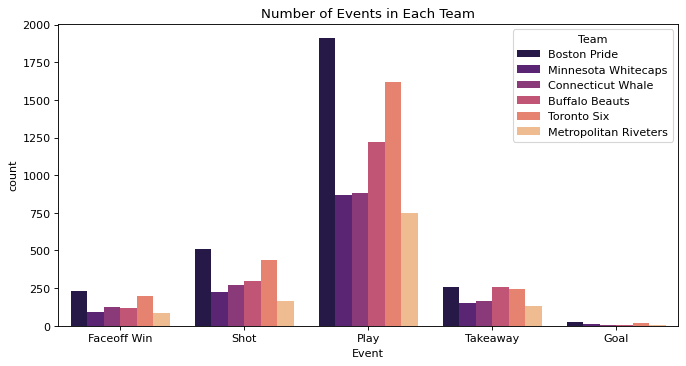

In [23]:
fig = plt.figure(figsize=(10, 5), dpi= 80)
sns.countplot(x = "Event", hue = "Team", data = df2, palette = 'magma').set_title('Number of Events in Each Team')


## IV.  Model Construction

### 1. Evaluation Score

In [24]:
df1.columns

Index(['Player', '# succesful passes', '# unsuccesful passes',
       'Success Pass Rate', '# Goals', '# Shots', 'Scoring Rate(%)',
       '# faceoff wins', '# takeaway wins', '# penalty take',
       '# penalty give'],
      dtype='object')

In [25]:
df1.iloc[:, 2:].astype(int)
df1.head()

,Player,# succesful passes,# unsuccesful passes,Success Pass Rate,# Goals,# Shots,Scoring Rate(%),# faceoff wins,# takeaway wins,# penalty take,# penalty give
0,Abbie Ives,13,3.0,0.812500,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,Allie Olnowich,23,7.0,0.766667,0.0,0.0,0.000000,0.0,5.0,0.0,0.0
2,Allie Thunstrom,45,24.0,0.652174,0.0,0.0,0.000000,1.0,14.0,2.0,2.0
3,Alyson Matteau,130,49.0,0.726257,0.0,0.0,0.000000,0.0,28.0,1.0,3.0
4,Alyssa Wohlfeiler,87,27.0,0.763158,1.0,24.0,4.166667,0.0,8.0,3.0,1.0


In [26]:
# Correlation Test
columns_of_factor = ['# succesful passes', '# unsuccesful passes', 'Success Pass Rate', '# Goals', '# Shots',
                       'Scoring Rate(%)', '# faceoff wins', '# takeaway wins', '# penalty take', '# penalty give']

correlation_matrix = df1[columns_of_factor].corr()
correlation_matrix

,# succesful passes,# unsuccesful passes,Success Pass Rate,# Goals,# Shots,Scoring Rate(%),# faceoff wins,# takeaway wins,# penalty take,# penalty give
# succesful passes,1.000000,0.860255,0.165558,0.324687,0.397435,0.034086,0.182055,0.694224,0.404525,0.307904
# unsuccesful passes,0.860255,1.000000,-0.222165,0.299325,0.377796,0.048195,0.155582,0.758663,0.403244,0.264219
Success Pass Rate,0.165558,-0.222165,1.000000,-0.014620,-0.007648,-0.082036,-0.018907,-0.114990,-0.132622,0.039568
# Goals,0.324687,0.299325,-0.014620,1.000000,0.848171,0.678129,0.148568,0.292208,0.105645,0.318918
# Shots,0.397435,0.377796,-0.007648,0.848171,1.000000,0.417714,0.167958,0.335564,0.168275,0.325924
Scoring Rate(%),0.034086,0.048195,-0.082036,0.678129,0.417714,1.000000,0.072896,0.120632,-0.039170,0.163171
# faceoff wins,0.182055,0.155582,-0.018907,0.148568,0.167958,0.072896,1.000000,0.403054,0.118434,0.179165
# takeaway wins,0.694224,0.758663,-0.114990,0.292208,0.335564,0.120632,0.403054,1.000000,0.269397,0.427634
# penalty take,0.404525,0.403244,-0.132622,0.105645,0.168275,-0.039170,0.118434,0.269397,1.000000,0.109793
# penalty give,0.307904,0.264219,0.039568,0.318918,0.325924,0.163171,0.179165,0.427634,0.109793,1.000000


In [27]:
# Normalization
scaler = MinMaxScaler()

columns_to_normalize = ['# succesful passes', '# unsuccesful passes',
       'Success Pass Rate', '# Goals', '# Shots', 'Scoring Rate(%)',
       '# faceoff wins', '# takeaway wins', '# penalty take',
       '# penalty give']

df1[columns_to_normalize] = scaler.fit_transform(df1[columns_to_normalize])

In [28]:
# Define Indicator Weights
weight1 = {
     '# succesful passes': 0.1,
     '# unsuccesful passes': 0.1, 
     'Success Pass Rate': 0.1,
     '# Goals' : 0.1,
     '# Shots' : 0.1,
     'Scoring Rate(%)' : 0.1,
     '# faceoff wins' : 0.1, 
     '# takeaway wins' : 0.1,
     '# penalty take': 0.1,
     '# penalty give': -0.1
}

# Calculate the Evaluation score of each player
scores = {}

for index, row in df1.iterrows():
    player_name = row['Player']
    player_scores = row[['# succesful passes', '# unsuccesful passes',
       'Success Pass Rate', '# Goals', '# Shots', 'Scoring Rate(%)',
       '# faceoff wins', '# takeaway wins', '# penalty take',
       '# penalty give']].astype(float)
    eva_score = sum(score * weight for score, weight in zip(player_scores, weight1.values()))
    
    if player_name in scores:
        scores[player_name].append(eva_score)
    else:
        scores[player_name] = [eva_score]
        
selected_players= sorted(scores, key=lambda x: x[1], reverse=True)[:]    


In [29]:
# Convert scores dictionary to DataFrame
df_eva_scores = pd.DataFrame.from_dict(scores, orient='index', columns=['Evaluation Score'])
df_eva_scores.reset_index(inplace=True)
df_eva_scores.columns = ['Player', 'Evaluation Score']
df_eva_scores.sort_values('Evaluation Score', ascending = False)
df_eva_scores.to_csv('df_eva_scores.csv')
df_eva_scores

,Player,Evaluation Score
0,Abbie Ives,0.078313
1,Allie Olnowich,0.096814
2,Allie Thunstrom,0.156591
3,Alyson Matteau,0.247391
4,Alyssa Wohlfeiler,0.278318
...,...,...
121,Tori Howran,0.214387
122,Tori Sullivan,0.099713
123,Victoria Hanson,0.108013
124,Whitney Dove,0.277014


In [30]:
# Merge data together 
df_eva = pd.merge(df1, df_eva_scores, on = 'Player', how = 'left')
df_eva.to_csv('player_eva_score.csv')
df_eva.head()

,Player,# succesful passes,# unsuccesful passes,Success Pass Rate,# Goals,# Shots,Scoring Rate(%),# faceoff wins,# takeaway wins,# penalty take,# penalty give,Evaluation Score
0,Abbie Ives,0.049793,0.033333,0.700000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.078313
1,Allie Olnowich,0.091286,0.077778,0.626667,0.0,0.000000,0.000000,0.000000,0.172414,0.0,0.000000,0.096814
2,Allie Thunstrom,0.182573,0.266667,0.443478,0.0,0.000000,0.000000,0.012658,0.482759,0.4,0.222222,0.156591
3,Alyson Matteau,0.535270,0.544444,0.562011,0.0,0.000000,0.000000,0.000000,0.965517,0.2,0.333333,0.247391
4,Alyssa Wohlfeiler,0.356846,0.300000,0.621053,0.2,0.436364,0.104167,0.000000,0.275862,0.6,0.111111,0.278318


`df_eva` is the data that contains each player's evaluation score, success pass rate, scoring rate and other factors.

## 2. Two ways to find the best 5 players.

This part aims to choose the best 5 players for the team based on the question.


### (1) Rank Choose

In [31]:
factors = ['# Goals','Scoring Rate(%)','# succesful passes','Success Pass Rate']
top_percentages = [0.3, 0.3, 0.1, 0.1]

df_top_players = pd.DataFrame(columns=factors)

# Iterate over the factors
for factor, top_percentage in zip(factors, top_percentages):
    # Calculate the number of players to select
    num_players = int(len(df_eva) * top_percentage)
    
    # Select the top players for the current factor based on the column values
    factor_top_players = df_eva.nlargest(num_players, factor)['Player'].reset_index(drop=True)
    
    # Assign the selected players to the corresponding column in the DataFrame
    df_top_players[factor] = factor_top_players
    
# Remove duplicates from the selected players
df_top_players = df_top_players.apply(lambda x: pd.Series(pd.unique(x)))
df_top_players

,# Goals,Scoring Rate(%),# succesful passes,Success Pass Rate
0,Mikyla Grant-Mentis,Leila Kilduff,Kaleigh Fratkin,Caty Flagg
1,Samantha Davis,Cailey Hutchison,Mallory Souliotis,Samantha Ridgewell
2,Taylor Woods,Winny Brodt-Brown,Sarah Steele,Victoria Hanson
3,Autumn MacDougall,Autumn MacDougall,Taylor Woods,Carly Jackson
4,Jillian Dempsey,Haley Mack,Shiann Darkangelo,Lovisa Selander
5,Mallory Souliotis,Audra Richards,Lindsay Eastwood,Amanda Leveille
6,McKenna Brand,Rebecca Russo,Taylor Turnquist,Brooke Wolejko
7,Audra Richards,Emily Janiga,Lauren Kelly,Elaine Chuli
8,Breanne Wilson-Bennett,Jillian Dempsey,McKenna Brand,Sonjia Shelly
9,Brooke Boquist,Meaghan Pezon,Tereza Vanisova,Tera Hofmann


In [32]:
# Find players who are ranked in the top 20 for both "# Goals" and "Scoring Rate(%)"
top_players_goals = df_top_players["# Goals"].tolist()[:20]
top_players_scoring_rate = df_top_players["Scoring Rate(%)"].tolist()[:20]
top_goal_players20 = [player for player in top_players_goals if player in top_players_scoring_rate]
df_top_goal_players20 = pd.DataFrame(top_goal_players20, columns = ['Player'])
df_top_goal_players20_t = df_eva[df_eva['Player'].isin(df_top_goal_players20['Player'])]
df_top_goal_players20_t.sort_values (by = ['Evaluation Score', '# faceoff wins', '# takeaway wins'], ascending = [False, False, False])

,Player,# succesful passes,# unsuccesful passes,Success Pass Rate,# Goals,# Shots,Scoring Rate(%),# faceoff wins,# takeaway wins,# penalty take,# penalty give,Evaluation Score
87,Mikyla Grant-Mentis,0.427386,0.488889,0.524324,1.0,0.890909,0.255102,0.240506,0.655172,0.6,0.000000,0.508229
44,Jillian Dempsey,0.327801,0.400000,0.503448,0.6,0.436364,0.312500,0.886076,0.758621,0.0,0.222222,0.400259
98,Samantha Davis,0.489627,0.533333,0.540120,0.8,0.618182,0.294118,0.063291,0.620690,0.2,0.444444,0.371492
61,Leila Kilduff,0.190871,0.222222,0.522388,0.4,0.090909,1.000000,0.000000,0.517241,0.0,0.000000,0.294363
91,Nina Rodgers,0.199170,0.188889,0.587879,0.4,0.309091,0.294118,0.012658,0.448276,0.6,0.111111,0.292897
58,Kristin Lewicki,0.336100,0.433333,0.484298,0.4,0.381818,0.238095,0.012658,0.586207,0.0,0.111111,0.276140
36,Haley Mack,0.253112,0.311111,0.502222,0.4,0.236364,0.384615,0.075949,0.137931,0.2,0.111111,0.239019
9,Autumn MacDougall,0.290456,0.533333,0.354622,0.6,0.327273,0.416667,0.000000,0.241379,0.0,0.444444,0.231929
82,Meaghan Rickard,0.116183,0.233333,0.328000,0.4,0.327273,0.277778,0.000000,0.413793,0.0,0.111111,0.198525
8,Audra Richards,0.107884,0.288889,0.215094,0.4,0.254545,0.357143,0.025316,0.172414,0.2,0.333333,0.168795


* There are 10 players who can rank top20 in both # Goals and scoring rate field.

In [33]:
# Choose top 10 great pass player
# Find players who are ranked in the top 10 for both "# succesful passes" and "Success Pass Rate"
top_players_pass = df_top_players['# succesful passes'].tolist()[:30]
top_players_pass_rate = df_top_players['Success Pass Rate'].tolist()[:30]
top_pass_players10 = [player for player in top_players_goals if player in top_players_pass_rate]
df_top_pass_players10 = df_top_players[['Success Pass Rate']][:10]
df_top_pass_players10 = df_top_pass_players10.rename(columns={'Success Pass Rate': 'Player'})
df_top_pass_players10_t = df_eva[df_eva['Player'].isin(df_top_pass_players10['Player'])]
df_top_pass_players10_t.sort_values (by = ['Evaluation Score', '# faceoff wins', '# takeaway wins'], ascending = [False, False, False])

,Player,# succesful passes,# unsuccesful passes,Success Pass Rate,# Goals,# Shots,Scoring Rate(%),# faceoff wins,# takeaway wins,# penalty take,# penalty give,Evaluation Score
20,Carly Jackson,0.199170,0.022222,0.937255,0.0,0.0,0.0,0.0,0.103448,0.0,0.000000,0.126210
123,Victoria Hanson,0.045643,0.000000,1.000000,0.0,0.0,0.0,0.0,0.034483,0.0,0.000000,0.108013
99,Samantha Ridgewell,0.037344,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.103734
66,Lovisa Selander,0.091286,0.011111,0.933333,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.103573
22,Caty Flagg,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.100000
26,Elaine Chuli,0.120332,0.044444,0.811765,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.097654
6,Amanda Leveille,0.128631,0.033333,0.862857,0.0,0.0,0.0,0.0,0.000000,0.0,0.111111,0.091371
17,Brooke Wolejko,0.037344,0.011111,0.854545,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.090300
109,Sonjia Shelly,0.045643,0.022222,0.771429,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.083929
118,Tera Hofmann,0.041494,0.022222,0.753846,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.081756


 **Brief Conclusion**: 

By Simply visual comparison, We can find that most of the top 10 players in pass rate and # successful passes perform poorly in all other fields,although most of them perform well in these two fields. Therefore, we decided to expand the range in the selection of top goals players and directly select directly from them at random to generate team combo.

In [34]:
# Find players who are ranked in the top 30 for both "# Goals" and "Scoring Rate(%)"
top_players_goals_ = df_top_players["# Goals"].tolist()[:30]
top_players_scoring_rate = df_top_players["Scoring Rate(%)"].tolist()[:30]
top_goal_players30 = [player for player in top_players_goals if player in top_players_scoring_rate]
#top_goal_players30
df_top_goal_players30 = pd.DataFrame(top_goal_players30, columns = ['Player'])
df_top_goal_players30_t = df_eva[df_eva['Player'].isin(df_top_goal_players30['Player'])]
df_top_goal_players30_t.sort_values (by = ['Evaluation Score', '# faceoff wins', '# takeaway wins'], ascending = [False, False, False])

,Player,# succesful passes,# unsuccesful passes,Success Pass Rate,# Goals,# Shots,Scoring Rate(%),# faceoff wins,# takeaway wins,# penalty take,# penalty give,Evaluation Score
87,Mikyla Grant-Mentis,0.427386,0.488889,0.524324,1.0,0.890909,0.255102,0.240506,0.655172,0.6,0.000000,0.508229
116,Taylor Woods,0.647303,0.511111,0.637438,0.8,0.763636,0.238095,0.025316,0.482759,1.0,0.222222,0.488344
44,Jillian Dempsey,0.327801,0.400000,0.503448,0.6,0.436364,0.312500,0.886076,0.758621,0.0,0.222222,0.400259
76,Mallory Souliotis,0.721992,0.933333,0.481081,0.6,0.581818,0.234375,0.000000,0.758621,0.0,0.444444,0.386678
98,Samantha Davis,0.489627,0.533333,0.540120,0.8,0.618182,0.294118,0.063291,0.620690,0.2,0.444444,0.371492
61,Leila Kilduff,0.190871,0.222222,0.522388,0.4,0.090909,1.000000,0.000000,0.517241,0.0,0.000000,0.294363
91,Nina Rodgers,0.199170,0.188889,0.587879,0.4,0.309091,0.294118,0.012658,0.448276,0.6,0.111111,0.292897
58,Kristin Lewicki,0.336100,0.433333,0.484298,0.4,0.381818,0.238095,0.012658,0.586207,0.0,0.111111,0.276140
50,Katelynn Russ,0.161826,0.333333,0.314286,0.4,0.472727,0.192308,0.075949,0.379310,0.4,0.000000,0.272974
14,Brooke Boquist,0.290456,0.344444,0.513725,0.4,0.490909,0.185185,0.025316,0.103448,0.4,0.222222,0.253126


In [35]:
num_players = 5

# Random selection of 5 players from 15 players
player_list = df_top_goal_players30_t['Player'].tolist()
team_combinations = list(combinations(player_list, num_players))

result_df = pd.DataFrame(columns=['Team', 'avg success pass rate', '# takeaway wins', '# faceoff wins', 'avg Evaluation Score'])


for team_players in team_combinations:
    team_data = df_top_goal_players30_t[df_top_goal_players30_t['Player'].isin(team_players)]
    success_pass_rate_sum = team_data['Success Pass Rate'].mean()
    takeaway_wins_sum = team_data['# takeaway wins'].sum()
    faceoff_wins_sum = team_data['# faceoff wins'].sum()
    evaluation_score_avg = team_data['Evaluation Score'].mean()
    team_name = ', '.join(team_players)
    team_info = {'Team': team_name,
                 'avg success pass rate': success_pass_rate_sum,
                 '# takeaway wins': takeaway_wins_sum,
                 '# faceoff wins': faceoff_wins_sum,
                 'avg Evaluation Score': evaluation_score_avg}
    result_df = result_df.append(team_info, ignore_index=True)


C:\Users\Yuan\AppData\Local\Temp\ipykernel_18288\520358526.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(team_info, ignore_index=True)
C:\Users\Yuan\AppData\Local\Temp\ipykernel_18288\520358526.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(team_info, ignore_index=True)
C:\Users\Yuan\AppData\Local\Temp\ipykernel_18288\520358526.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_df.append(team_info, ignore_index=True)
C:\Users\Yuan\AppData\Local\Temp\ipykernel_18288\520358526.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_df = result_

In [36]:
result_df.to_csv('team_combo.csv')

In [37]:
team1 = result_df.sort_values(by = ['avg Evaluation Score','avg success pass rate', '# faceoff wins', '# takeaway wins'], ascending = [False, False, False, False])
team1.iloc[0,0]

'Jillian Dempsey, Leila Kilduff, Mikyla Grant-Mentis, Nina Rodgers, Samantha Davis'

* Base on the result above, we choose Jillian Dempsey, Mallory Souliotis, Mikyla Grant-Mentis, Samantha Davis, Taylor Woods as Team1


### (2) Genetic Algorithm



In [38]:
df_gl = df_top_goal_players30_t 

In [39]:
# Get a list of all players
players = df_gl['Player'].tolist()

# Define the evaluation function (objective function)
def evaluate(individual):
    selected_players = [player for i, player in enumerate(players) if individual[i]]
    num_success_pass = np.sum(df_gl.loc[df_gl['Player'].isin(selected_players), '# succesful passes'])
    faceoff_specialists = np.sum(df_gl.loc[df_gl['Player'].isin(selected_players), '# faceoff wins'])
    takeaway_specialists = np.sum(df_gl.loc[df_gl['Player'].isin(selected_players), '# takeaway wins'])
    evaluation_score = np.mean(df_gl.loc[df_gl['Player'].isin(selected_players), 'Evaluation Score'])
    return  num_success_pass, faceoff_specialists, takeaway_specialists, evaluation_score

# Optimization objective is maximization
creator.create("FitnessMax", base.Fitness, weights=(0.3, 0.2, 0.2, 0.3))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Initializing the Genetic Algorithm Toolbox
toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.choice, [0, 1])
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, len(players))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Registering Operators for Genetic Algorithms
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Define the parameters of the genetic algorithm
population_size = 100
generations = 30

# Create initial populations
population = toolbox.population(n=population_size)

# Genetic algorithms
for gen in range(generations):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.1)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=population_size)

# Selecting the optimal solution
best_individual = tools.selBest(population, k=1)[0]
selected_players = [player for i, player in enumerate(players) if best_individual[i]]

# Trimmed to 5 players
if len(selected_players) > 5:
    selected_players = selected_players[:5]

print("Selected Players:")
for player in selected_players:
    print(player)


Selected Players:
Audra Richards
Autumn MacDougall
Brooke Boquist
Haley Mack
Jillian Dempsey


In [40]:
team2 = pd.DataFrame(selected_players, columns = ['Player'])
team2

,Player
0,Audra Richards
1,Autumn MacDougall
2,Brooke Boquist
3,Haley Mack
4,Jillian Dempsey


In [41]:
df_fplayer_eva = df_eva[df_eva['Player'].isin(team2['Player'])]
df_fplayer_eva

,Player,# succesful passes,# unsuccesful passes,Success Pass Rate,# Goals,# Shots,Scoring Rate(%),# faceoff wins,# takeaway wins,# penalty take,# penalty give,Evaluation Score
8,Audra Richards,0.107884,0.288889,0.215094,0.4,0.254545,0.357143,0.025316,0.172414,0.2,0.333333,0.168795
9,Autumn MacDougall,0.290456,0.533333,0.354622,0.6,0.327273,0.416667,0.000000,0.241379,0.0,0.444444,0.231929
14,Brooke Boquist,0.290456,0.344444,0.513725,0.4,0.490909,0.185185,0.025316,0.103448,0.4,0.222222,0.253126
36,Haley Mack,0.253112,0.311111,0.502222,0.4,0.236364,0.384615,0.075949,0.137931,0.2,0.111111,0.239019
44,Jillian Dempsey,0.327801,0.400000,0.503448,0.6,0.436364,0.312500,0.886076,0.758621,0.0,0.222222,0.400259


In [42]:
#df_selected_players.to_csv('selected_players.csv')

## V. Evaluation & Testing

The goal of this section is to determine whether the players we selected by the two different methods are reasonable, and to compare the data of the two teams of players to choose the best one.

### 1. Statistics

In [43]:
# use the copy of df1 to do the stats job
df_stats.describe()

,# succesful passes,# unsuccesful passes,Success Pass Rate,# Goals,# Shots,Scoring Rate(%),# faceoff wins,# takeaway wins,# penalty take,# penalty give
count,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000,126.000000
mean,57.531746,27.222222,0.674499,0.603175,7.904762,3.510550,6.714286,9.579365,1.142857,1.079365
std,43.706418,18.657712,0.119136,0.988570,12.920946,6.082336,14.636861,6.978084,1.389758,1.445562
min,1.000000,0.000000,0.375000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.500000,14.250000,0.595968,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
50%,47.000000,24.500000,0.676166,0.000000,0.000000,0.000000,0.000000,8.500000,1.000000,1.000000
75%,80.000000,39.000000,0.734892,1.000000,13.000000,6.401210,4.000000,14.000000,2.000000,2.000000
max,242.000000,90.000000,1.000000,5.000000,55.000000,40.000000,79.000000,29.000000,5.000000,9.000000


In [44]:
from scipy import stats
# the number is from the combo (JD, MS, MGM, SD, TW)
num_goal = 19 / 5
num_pass = 635 / 5
num_takeaway = 95 / 5
num_faceoff = 96 / 5

percentile_goal = stats.percentileofscore(df_stats["# Goals"], num_goal)
print("Goal: " + str(percentile_goal))
percentile_pass = stats.percentileofscore(df_stats["# succesful passes"], num_pass)
print("Pass: " + str(percentile_pass))
percentile_takeaway = stats.percentileofscore(df_stats["# takeaway wins"], num_takeaway)
print("Takeaway: " + str(percentile_takeaway))
percentile_faceoff = stats.percentileofscore(df_stats["# faceoff wins"], num_faceoff)
print("Faceoff: " + str(percentile_faceoff))

Goal: 97.61904761904762
Pass: 90.47619047619047
Takeaway: 89.68253968253968
Faceoff: 88.88888888888889


### 2. Cluster

In [45]:
# get the X, Y pos
df_pos = df[["Player", "X Coordinate", "Y Coordinate"]]
# sorted by players name
df_pos = df_pos.sort_values(by=["Player"], ascending=[True])
df_pos.reset_index(inplace=True,drop=True)
df_pos.head()

,Player,X Coordinate,Y Coordinate
0,Abbie Ives,1,44
1,Abbie Ives,4,41
2,Abbie Ives,4,41
3,Abbie Ives,3,43
4,Abbie Ives,3,42


In [46]:
# convert shot X, Y to list
x_coor = df_pos["X Coordinate"].values.tolist()
y_coor = df_pos["Y Coordinate"].values.tolist()
name = df_pos["Player"].values.tolist()
# start from the first player's name
s_name = name[0]
# temporary x, y position
x_list = []
y_list = []
# store the players result to dic
pos = {}
for i in range(len(name)):
    x_list.append(x_coor[i])
    y_list.append(y_coor[i])
    # if at the end of list
    if i == len(name) - 1:
        pos[s_name] = (x_list, y_list)
        continue
    # if the next player's name is others
    if s_name != name[i + 1]:
        pos[s_name] = (x_list, y_list)
        s_name = name[i + 1]
        x_list = []
        y_list = []

In [47]:
# use cluster to find the center point after clustering, using two point and get the average
x_list = []
y_list = []
for i in pos.keys():
    # x _coordinate
    test = []
    for j in range(len(pos[i][0])):
        test.append((pos[i][0][j], pos[i][1][j]))
    x_co = MiniBatchKMeans(n_clusters = 2, n_init = 100)
    x_co.fit(test)
    x = (x_co.cluster_centers_[0][0] + x_co.cluster_centers_[1][0]) / 2
    y = (x_co.cluster_centers_[0][1] + x_co.cluster_centers_[1][1]) / 2
    x_list.append(x)
    y_list.append(y)
df_xy = pd.DataFrame(data = {"X position": x_list, "Y position": y_list})
df_xy.head()

,X position,Y position
0,7.521564,40.333449
1,74.678123,59.094104
2,110.855336,54.306810
3,75.910121,36.989037
4,106.953612,30.159120


In [48]:
# Merge info
df1 = df_shots_goals_passes_faceoff_takeaway_pen.join(df_xy)
#df1 = df1[["# succesful passes", "# unsuccesful passes", "Success Pass Rate", "# Goals","# Shots","Scoring Rate(%)", "# faceoff wins", "# takeaway wins", "# penalty take", "# penalty give"]].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
#df1 = df1.clip(lower = 0.000001, upper = 0.999999)
#df1[['Player']] = df_shots_goals_passes_faceoff_takeaway_pen[['Player']]
df1 = df1[['Player', "# succesful passes", "# unsuccesful passes", "Success Pass Rate", "# Goals","# Shots","Scoring Rate(%)", "# faceoff wins", "# takeaway wins", "# penalty take", "# penalty give", "X position", "Y position"]]
df1
#df1.to_csv("df_info.csv")

,Player,# succesful passes,# unsuccesful passes,Success Pass Rate,# Goals,# Shots,Scoring Rate(%),# faceoff wins,# takeaway wins,# penalty take,# penalty give,X position,Y position
0,Abbie Ives,13,3.0,0.812500,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,7.521564,40.333449
1,Allie Olnowich,23,7.0,0.766667,0.0,0.0,0.000000,0.0,5.0,0.0,0.0,74.678123,59.094104
2,Allie Thunstrom,45,24.0,0.652174,0.0,0.0,0.000000,1.0,14.0,2.0,2.0,110.855336,54.306810
3,Alyson Matteau,130,49.0,0.726257,0.0,0.0,0.000000,0.0,28.0,1.0,3.0,75.910121,36.989037
4,Alyssa Wohlfeiler,87,27.0,0.763158,1.0,24.0,4.166667,0.0,8.0,3.0,1.0,106.953612,30.159120
...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,Tori Howran,74,35.0,0.678899,1.0,13.0,7.692308,0.0,13.0,0.0,1.0,82.271091,31.240705
122,Tori Sullivan,86,16.0,0.843137,0.0,0.0,0.000000,1.0,14.0,0.0,7.0,112.103709,38.898632
123,Victoria Hanson,12,0.0,1.000000,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,10.170413,40.157935
124,Whitney Dove,105,51.0,0.673077,0.0,0.0,0.000000,0.0,15.0,5.0,2.0,75.360110,34.865373


* Finished the preprocess for Clustering data

In [49]:
# Remove the player name at first, str cannot use for cluster
score_list = []
for index, row in df1.iterrows():
    player_scores = row['# Goals':].astype(float).values
    score_list.append(player_scores)
score_list

[array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  7.52156405, 40.33344874]),
 array([ 0.        ,  0.        ,  0.        ,  0.        ,  5.        ,
         0.        ,  0.        , 74.67812269, 59.09410395]),
 array([  0.        ,   0.        ,   0.        ,   1.        ,
         14.        ,   2.        ,   2.        , 110.85533638,
         54.30680954]),
 array([ 0.        ,  0.        ,  0.        ,  0.        , 28.        ,
         1.        ,  3.        , 75.91012073, 36.98903676]),
 array([  1.        ,  24.        ,   4.16666667,   0.        ,
          8.        ,   3.        ,   1.        , 106.95361201,
         30.15911957]),
 array([  1.        ,  10.        ,  10.        ,   0.        ,
          3.        ,   0.        ,   0.        , 109.95309088,
         51.72361556]),
 array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  9.78190998, 41.4162902 ]),
 arr

In [50]:
# PCA at first, reduce the dimension, and then cluster
pca = PCA(n_components = 5)
pca = pca.fit_transform(score_list)
y_pred = KMeans(n_clusters = 8, random_state = 9, n_init = 100).fit_predict(pca)
y_pred

array([2, 6, 1, 3, 4, 1, 2, 7, 1, 4, 5, 3, 6, 3, 4, 7, 6, 2, 1, 5, 2, 5,
       2, 6, 4, 6, 2, 3, 7, 1, 3, 3, 5, 1, 7, 1, 7, 3, 1, 7, 7, 7, 1, 6,
       5, 4, 5, 1, 6, 7, 4, 7, 5, 1, 1, 1, 6, 6, 4, 6, 0, 6, 3, 5, 0, 1,
       2, 3, 1, 4, 7, 6, 1, 7, 3, 7, 0, 2, 6, 7, 4, 7, 4, 6, 6, 1, 4, 4,
       7, 1, 7, 7, 6, 1, 1, 3, 7, 6, 4, 2, 3, 6, 7, 1, 3, 4, 3, 6, 5, 2,
       5, 0, 6, 6, 1, 4, 0, 1, 2, 5, 1, 3, 7, 2, 3, 3])

In [51]:
# get all player's group (assign every player into a group that contain all players with similar attribute)
df_c = pd.DataFrame(data = {"Group": y_pred})
df_cl  = df1.join(df_c)
df_cl

,Player,# succesful passes,# unsuccesful passes,Success Pass Rate,# Goals,# Shots,Scoring Rate(%),# faceoff wins,# takeaway wins,# penalty take,# penalty give,X position,Y position,Group
0,Abbie Ives,13,3.0,0.812500,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,7.521564,40.333449,2
1,Allie Olnowich,23,7.0,0.766667,0.0,0.0,0.000000,0.0,5.0,0.0,0.0,74.678123,59.094104,6
2,Allie Thunstrom,45,24.0,0.652174,0.0,0.0,0.000000,1.0,14.0,2.0,2.0,110.855336,54.306810,1
3,Alyson Matteau,130,49.0,0.726257,0.0,0.0,0.000000,0.0,28.0,1.0,3.0,75.910121,36.989037,3
4,Alyssa Wohlfeiler,87,27.0,0.763158,1.0,24.0,4.166667,0.0,8.0,3.0,1.0,106.953612,30.159120,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,Tori Howran,74,35.0,0.678899,1.0,13.0,7.692308,0.0,13.0,0.0,1.0,82.271091,31.240705,3
122,Tori Sullivan,86,16.0,0.843137,0.0,0.0,0.000000,1.0,14.0,0.0,7.0,112.103709,38.898632,7
123,Victoria Hanson,12,0.0,1.000000,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,10.170413,40.157935,2
124,Whitney Dove,105,51.0,0.673077,0.0,0.0,0.000000,0.0,15.0,5.0,2.0,75.360110,34.865373,3


In [52]:
# get only the group info
df_group = df_cl[["Player", "Group"]]
df_group.head()

,Player,Group
0,Abbie Ives,2
1,Allie Olnowich,6
2,Allie Thunstrom,1
3,Alyson Matteau,3
4,Alyssa Wohlfeiler,4


#### Find player pass to same group

In [53]:
# Complete pass, with passer and passed info
df_plays = df[df["Event"].isin(["Play"])]
df_plays.reset_index(inplace=True,drop=True)
df_plays_grouped = pd.DataFrame(df_plays.groupby(["Player","Player 2"])["game_date"].count())
df_plays_grouped.reset_index(inplace=True)
df_plays_grouped.sort_values(by=["game_date"],inplace=True,ascending=False)
df_plays_grouped.columns = ["Player_passer","Player_passed","# succesful passes"]
df_plays_grouped

,Player_passer,Player_passed,# succesful passes
529,Kaleigh Fratkin,Mallory Souliotis,53
847,Mallory Souliotis,Kaleigh Fratkin,51
531,Kaleigh Fratkin,McKenna Brand,49
251,Christina Putigna,McKenna Brand,41
34,Alyson Matteau,Marie-Jo Pelletier,36
...,...,...,...
190,Carlee Turner,Christina Putigna,1
191,Carlee Turner,Jenna Rheault,1
192,Carlee Turner,Kaleigh Fratkin,1
843,Mallory Souliotis,Briana Mastel,1


In [54]:
# Incomplete Play
df_Inplays = df[df["Event"].isin(["Incomplete Play"])]
df_Inplays.reset_index(inplace=True,drop=True)
df_Inplays_grouped = pd.DataFrame(df_Inplays.groupby(["Player","Player 2"])["game_date"].count())
df_Inplays_grouped.reset_index(inplace=True)
df_Inplays_grouped.sort_values(by=["game_date"],inplace=True,ascending=False)
df_Inplays_grouped.columns = ["Player_passer","Player_passed","# unsuccesful passes"]
df_Inplays_grouped

,Player_passer,Player_passed,# unsuccesful passes
378,Kaleigh Fratkin,McKenna Brand,23
359,Jordan Juron,Kristin Lewicki,22
168,Christina Putigna,McKenna Brand,20
69,Autumn MacDougall,Kristin Lewicki,19
346,Jillian Dempsey,McKenna Brand,18
...,...,...,...
501,Leila Kilduff,Paige Voight,1
502,Leila Kilduff,Rebecca Morse,1
504,Leila Kilduff,Theresa Knutson,1
505,Lenka Curmova,Alyson Matteau,1


In [55]:
# Success Play Ratio
df_plays_inplays_merged = pd.merge(df_plays_grouped, df_Inplays_grouped, left_on=["Player_passer", "Player_passed"], right_on=["Player_passer", "Player_passed"], how = 'left')
df_plays_inplays_merged.fillna(value = 0, inplace = True)
df_plays_inplays_merged["Success Pass Rate"] = df_plays_inplays_merged["# succesful passes"] / (df_plays_inplays_merged["# succesful passes"] + df_plays_inplays_merged["# unsuccesful passes"])
df_passer = df_plays_inplays_merged.sort_values(by=["Player_passer", "# succesful passes", "Success Pass Rate"], ascending=[True, False, False])
df_passed = df_plays_inplays_merged.sort_values(by=["Player_passed", "# succesful passes", "Success Pass Rate"], ascending=[True, False, False])
# df_passer_group: for every passer, group the passed player group to find which group she is familiar to pass to
df_passer_group = pd.merge(df_passer, df_group, left_on=["Player_passed"], right_on=["Player"], how = 'left')
# df_passed_group: for every passed, group the passer player group to find which group she is familiar to receive the pass
df_passed_group = pd.merge(df_passed, df_group, left_on=["Player_passer"], right_on=["Player"], how = 'left')
df_passer_group

,Player_passer,Player_passed,# succesful passes,# unsuccesful passes,Success Pass Rate,Player,Group
0,Abbie Ives,Shannon Doyle,4,0.0,1.000000,Shannon Doyle,6
1,Abbie Ives,Tori Howran,4,1.0,0.800000,Tori Howran,3
2,Abbie Ives,Maggie LaGue,3,0.0,1.000000,Maggie LaGue,3
3,Abbie Ives,Janine Weber,1,0.0,1.000000,Janine Weber,7
4,Abbie Ives,Taylor Marchin,1,1.0,0.500000,Taylor Marchin,6
...,...,...,...,...,...,...,...
1440,Winny Brodt-Brown,Audra Richards,2,3.0,0.400000,Audra Richards,1
1441,Winny Brodt-Brown,Lynn Astrup,1,0.0,1.000000,Lynn Astrup,3
1442,Winny Brodt-Brown,Rose Alleva,1,1.0,0.500000,Rose Alleva,6
1443,Winny Brodt-Brown,Meaghan Pezon,1,1.0,0.500000,Meaghan Pezon,7


### Player select

In [56]:
# Top 30% team combo (Team 1)
player_name_list = ['Jillian Dempsey', 'Mallory Souliotis', 'Mikyla Grant-Mentis', 'Samantha Davis', 'Taylor Woods']
# Genetic Algorithm (Team 2)
#player_name_list = ['Jillian Dempsey', 'Audra Richards', 'Autumn MacDougall', 'Haley Mack', 'Brooke Boquist']

In [57]:
# Let the player to be passer in this section, find out which group she would like to pass
passer_dic = {}
for player_name in player_name_list:
    df_row = df_passer_group[df_passer_group["Player_passer"].isin([player_name])]
    df_row.reset_index(inplace=True,drop=True)
    df_row = df_row.iloc[:3,:]
    passer_dic[player_name] = df_row["Group"].values
passer_dic

{'Jillian Dempsey': array([4, 4, 6]),
 'Mallory Souliotis': array([6, 7, 4]),
 'Mikyla Grant-Mentis': array([0, 0, 1]),
 'Samantha Davis': array([5, 6, 6]),
 'Taylor Woods': array([4, 0, 3])}

In [58]:
# Let the player to be passed in this section, find out which group she would like to receive pass
passed_dic = {}
for player_name in player_name_list:
    df_row = df_passed_group[df_passed_group["Player_passed"].isin([player_name])]
    df_row.reset_index(inplace=True,drop=True)
    df_row = df_row.iloc[:3,:]
    passed_dic[player_name] = df_row["Group"].values
passed_dic

{'Jillian Dempsey': array([4, 4, 6]),
 'Mallory Souliotis': array([6, 7, 4]),
 'Mikyla Grant-Mentis': array([0, 1, 7]),
 'Samantha Davis': array([5, 6, 0]),
 'Taylor Woods': array([4, 3, 0])}

In [59]:
# Get the group that player's in.
group_dic = {}
for player_name in player_name_list:
    group = df_group[df_group["Player"].isin([player_name])]
    group_dic[player_name] = group["Group"].values
group_dic

{'Jillian Dempsey': array([5]),
 'Mallory Souliotis': array([0]),
 'Mikyla Grant-Mentis': array([4]),
 'Samantha Davis': array([4]),
 'Taylor Woods': array([0])}

## 3. Position

In [60]:
#import matplotlib.pyplot as plt
# %matplotlib auto

### (1) Player select

In [61]:
# Top 30% team combo (Team 1)
player_name_list = ['Jillian Dempsey', 'Mallory Souliotis', 'Mikyla Grant-Mentis', 'Samantha Davis', 'Taylor Woods']
# Genetic Algorithm (Team 2)
#player_name_list = ['Jillian Dempsey', 'Audra Richards', 'Autumn MacDougall', 'Haley Mack', 'Brooke Boquist']

### (2) Graph

#### shot

In [62]:
# Select shot data
df_goal_shot = df[df["Event"].isin(["Shot"])]
# get the X, Y pos
df_shot_pos = df_goal_shot[["Player", "X Coordinate", "Y Coordinate"]]
# sorted by players name
df_shot_pos = df_shot_pos.sort_values(by=["Player"], ascending=[True])
df_shot_pos.reset_index(inplace=True,drop=True)

In [63]:
# convert shot X, Y to list
x_coor = df_shot_pos["X Coordinate"].values.tolist()
y_coor = df_shot_pos["Y Coordinate"].values.tolist()
name = df_shot_pos["Player"].values.tolist()
# start from the first player's name
s_name = name[0]
# temporary x, y position
x_list = []
y_list = []
# store the players result to dic
shot_pos = {}
for i in range(len(name)):
    x_list.append(x_coor[i])
    y_list.append(y_coor[i])
    # if at the end of list
    if i == len(name) - 1:
        shot_pos[s_name] = (x_list, y_list)
        continue
    # if the next player's name is others
    if s_name != name[i + 1]:
        shot_pos[s_name] = (x_list, y_list)
        s_name = name[i + 1]
        x_list = []
        y_list = []

#### Goal

In [64]:
# Select only goal data
df_goal_shot = df[df["Event"].isin(["Goal"])]
# get the X, Y pos
df_goal_pos = df_goal_shot[["Player", "X Coordinate", "Y Coordinate"]]
# sorted by players name
df_goal_pos = df_goal_pos.sort_values(by=["Player"], ascending=[True])
df_goal_pos.reset_index(inplace=True,drop=True)


In [65]:
total_goal = 0
# convert shot X, Y to list
x_coor = df_goal_pos["X Coordinate"].values.tolist()
y_coor = df_goal_pos["Y Coordinate"].values.tolist()
name = df_goal_pos["Player"].values.tolist()
# start from the first player's name
s_name = name[0]
# temporary x, y position
x_list = []
y_list = []
# store the players result to dic
goal_pos = {}
for i in range(len(name)):
    x_list.append(x_coor[i])
    y_list.append(y_coor[i])
    # if at the end of list
    if i == len(name) - 1:
        goal_pos[s_name] = (x_list, y_list)
        continue
    # if the next player's name is others
    if s_name != name[i + 1]:
        goal_pos[s_name] = (x_list, y_list)
        s_name = name[i + 1]
        x_list = []
        y_list = []
for player_name in player_name_list:
    if goal_pos.get(player_name) != None:
        total_goal += len(goal_pos[player_name][0])
total_goal

19

<Figure size 432x288 with 0 Axes>

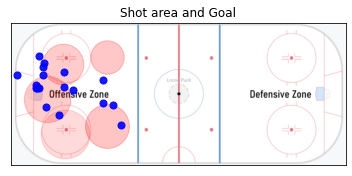

In [66]:
plt.figure()
img = plt.imread('bg1.jpg')
fig,ax=plt.subplots()
ax.imshow(img,extent=[200, 0, 0, 85])
test = []
for player_name in player_name_list:
    for i in range(len(shot_pos[player_name][0])):
        test.append((shot_pos[player_name][0][i], shot_pos[player_name][1][i]))
esti = MiniBatchKMeans(n_clusters = 5, n_init = 100)
esti.fit(test)
esti.labels_
esti.cluster_centers_
counts = Counter(esti.labels_)
d1, d2, d3, d4, d5 = [], [], [], [], []
for i in range(len(esti.labels_)):
    if esti.labels_[i] == 0:
        d1.append(test[i])
    elif esti.labels_[i] == 1:
        d2.append(test[i])
    elif esti.labels_[i] == 2:
        d3.append(test[i])
    elif esti.labels_[i] == 3:
        d4.append(test[i])
    elif esti.labels_[i] == 4:
        d5.append(test[i])
if len(d1) > 1:
    sz1 = (max(d1[0]) - min(d1[0])) + (max(d1[1]) - min(d1[1]))
else:
    sz1 = 0
if len(d2) > 1:
    sz2 = (max(d2[0]) - min(d2[0])) + (max(d2[1]) - min(d2[1]))
else:
    sz2 = 0
if len(d3) > 1:
    sz3 = (max(d3[0]) - min(d3[0])) + (max(d3[1]) - min(d3[1]))
else:
    sz3 = 0
if len(d4) > 1:
    sz4 = (max(d4[0]) - min(d4[0])) + (max(d4[1]) - min(d4[1]))
else:
    sz4 = 0
if len(d5) > 1:
    sz5 = (max(d5[0]) - min(d5[0])) + (max(d5[1]) - min(d5[1]))
else:
    sz5 = 0
sz = []
sz.append(sz1)
sz.append(sz2)
sz.append(sz3)
sz.append(sz4)
sz.append(sz5)
for i in range(esti.n_clusters):
    plt.scatter(esti.cluster_centers_[i][0], esti.cluster_centers_[i][1], marker = 'o', c = 'red', alpha = counts[i]/len(esti.labels_), s = (sz[i] * 8))
    # for i in range(len(d1)):
    #     plt.scatter(d1[i][0], d1[i][1], marker = 'o', c = 'blue', alpha = 0.5, s = 50)
    # for i in range(len(d2)):
    #     plt.scatter(d2[i][0], d2[i][1], marker = 'o', c = 'green', alpha = 0.5, s = 50)
    # for i in range(len(d3)):
    #     plt.scatter(d3[i][0], d3[i][1], marker = 'o', c = 'yellow', alpha = 0.5, s = 50)
for player_name in player_name_list:
    plt.scatter(goal_pos[player_name][0], goal_pos[player_name][1], marker = 'o', c = 'blue', alpha = 0.9, s = 50)
plt.title("Shot area and Goal", loc = 'center')
plt.xticks([])
plt.yticks([])
plt.show()

#### Pass

In [67]:
# Select only goal data
df_pass = df[df["Event"].isin(["Play"])]
# get the X, Y pos
df_pass_pos = df_pass[["Player", "X Coordinate", "Y Coordinate", "X Coordinate 2", "Y Coordinate 2"]]
# sorted by players name
df_pass_pos = df_pass_pos.sort_values(by=["Player"], ascending=[True])
df_pass_pos.reset_index(inplace=True,drop=True)
df_pass_pos


,Player,X Coordinate,Y Coordinate,X Coordinate 2,Y Coordinate 2
0,Abbie Ives,2,35,2.0,35.0
1,Abbie Ives,3,35,3.0,35.0
2,Abbie Ives,1,45,1.0,45.0
3,Abbie Ives,2,36,2.0,36.0
4,Abbie Ives,0,44,0.0,44.0
...,...,...,...,...,...
7244,Winny Brodt-Brown,8,73,23.0,82.0
7245,Winny Brodt-Brown,136,56,143.0,31.0
7246,Winny Brodt-Brown,131,42,147.0,11.0
7247,Winny Brodt-Brown,3,50,9.0,18.0


In [68]:
total_pass = 0
# convert shot X, Y to list
x_coor = df_pass_pos["X Coordinate"].values.tolist()
y_coor = df_pass_pos["Y Coordinate"].values.tolist()
x_coor2 = df_pass_pos["X Coordinate 2"].values.tolist()
y_coor2 = df_pass_pos["Y Coordinate 2"].values.tolist()
name = df_pass_pos["Player"].values.tolist()
# start from the first player's name
s_name = name[0]
# temporary x, y position
x_list = []
y_list = []
x2_list = []
y2_list = []
# store the players result to dic
pass_pos = {}
for i in range(len(name)):
    x_list.append(x_coor[i])
    y_list.append(y_coor[i])
    x2_list.append(x_coor2[i])
    y2_list.append(y_coor2[i])
    # if at the end of list
    if i == len(name) - 1:
        pass_pos[s_name] = (x_list, y_list, x2_list, y2_list)
        continue
    # if the next player's name is others
    if s_name != name[i + 1]:
        pass_pos[s_name] = (x_list, y_list, x2_list, y2_list)
        s_name = name[i + 1]
        x_list = []
        y_list = []
        x2_list = []
        y2_list = []
for player_name in player_name_list:
    if pass_pos.get(player_name) != None:
        total_pass += len(pass_pos[player_name][0])
total_pass

635

<Figure size 432x288 with 0 Axes>

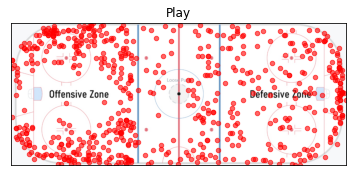

In [69]:
plt.figure()
img = plt.imread('bg1.jpg')
fig,ax=plt.subplots()
ax.imshow(img,extent=[200, 0, 0, 85])
#plt.scatter([pass_pos[player_name][0], pass_pos[player_name][1]], [pass_pos[player_name][2], pass_pos[player_name][3]], c = 'blue')
#plt.plot([pass_pos[player_name][0], pass_pos[player_name][1]], [pass_pos[player_name][2], pass_pos[player_name][3]], c = 'red')
for player_name in player_name_list:
    plt.scatter(pass_pos[player_name][0], pass_pos[player_name][1], marker = 'o', c = 'red', alpha = 0.6, s = 20)
plt.xticks([])
plt.yticks([])
plt.title("Play", loc = 'center')
plt.show()

<Figure size 432x288 with 0 Axes>

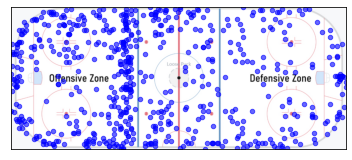

In [70]:
plt.figure()
img = plt.imread('bg1.jpg')
fig,ax=plt.subplots()
ax.imshow(img,extent=[200, 0, 0, 85])
#plt.scatter([pass_pos[player_name][0], pass_pos[player_name][1]], [pass_pos[player_name][2], pass_pos[player_name][3]], c = 'blue')
#plt.plot([pass_pos[player_name][0], pass_pos[player_name][1]], [pass_pos[player_name][2], pass_pos[player_name][3]], c = 'red')
for player_name in player_name_list:
    plt.scatter(pass_pos[player_name][2], pass_pos[player_name][3], marker = 'o', c = 'blue', alpha = 0.6, s = 20)
plt.xticks([])
plt.yticks([])
plt.show()

#### Takeaway

In [71]:
# Select only goal data
df_takeaway = df[df["Event"].isin(["Takeaway"])]
# get the X, Y pos
df_takeaway_pos = df_takeaway[["Player", "X Coordinate", "Y Coordinate"]]
# sorted by players name
df_takeaway_pos = df_takeaway_pos.sort_values(by=["Player"], ascending=[True])
df_takeaway_pos.reset_index(inplace=True,drop=True)


In [72]:
total_takeaway = 0
# convert shot X, Y to list
x_coor = df_takeaway_pos["X Coordinate"].values.tolist()
y_coor = df_takeaway_pos["Y Coordinate"].values.tolist()
name = df_takeaway_pos["Player"].values.tolist()
# start from the first player's name
s_name = name[0]
# temporary x, y position
x_list = []
y_list = []
# store the players result to dic
take_pos = {}
for i in range(len(name)):
    x_list.append(x_coor[i])
    y_list.append(y_coor[i])
    # if at the end of list
    if i == len(name) - 1:
        take_pos[s_name] = (x_list, y_list)
        continue
    # if the next player's name is others
    if s_name != name[i + 1]:
        take_pos[s_name] = (x_list, y_list)
        s_name = name[i + 1]
        x_list = []
        y_list = []
for player_name in player_name_list:
    if take_pos.get(player_name) != None:
        total_takeaway += len(take_pos[player_name][0])
total_takeaway

95

<Figure size 432x288 with 0 Axes>

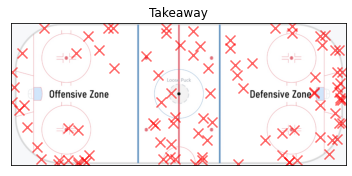

In [73]:
plt.figure()
img = plt.imread('bg1.jpg')
fig,ax=plt.subplots()
ax.imshow(img,extent=[200, 0, 0, 85])
for player_name in player_name_list:
    plt.scatter(take_pos[player_name][0], take_pos[player_name][1], marker = 'x', c = 'red', alpha = 0.6, s = 100)
plt.xticks([])
plt.yticks([])
plt.title("Takeaway", loc = 'center')
plt.show()

#### Faceoff

In [74]:
# Select only goal data
df_faceoff = df[df["Event"].isin(["Faceoff Win"])]
# get the X, Y pos
df_faceoff_pos = df_faceoff[["Player", "X Coordinate", "Y Coordinate"]]
# sorted by players name
df_faceoff_pos = df_faceoff_pos.sort_values(by=["Player"], ascending=[True])
df_faceoff_pos.reset_index(inplace=True,drop=True)
df_faceoff_pos


,Player,X Coordinate,Y Coordinate
0,Allie Thunstrom,31,64
1,Amy Curlew,100,43
2,Amy Curlew,169,21
3,Amy Curlew,80,64
4,Amy Curlew,169,64
...,...,...,...
841,Tereza Vanisova,80,65
842,Tereza Vanisova,169,20
843,Theresa Knutson,31,21
844,Theresa Knutson,169,65


In [75]:
total_faceoff = 0
# convert shot X, Y to list
x_coor = df_faceoff_pos["X Coordinate"].values.tolist()
y_coor = df_faceoff_pos["Y Coordinate"].values.tolist()
name = df_faceoff_pos["Player"].values.tolist()
# start from the first player's name
s_name = name[0]
# temporary x, y position
x_list = []
y_list = []
# store the players result to dic
faceoff_pos = {}
for i in range(len(name)):
    x_list.append(x_coor[i])
    y_list.append(y_coor[i])
    # if at the end of list
    if i == len(name) - 1:
        faceoff_pos[s_name] = (x_list, y_list)
        continue
    # if the next player's name is others
    if s_name != name[i + 1]:
        faceoff_pos[s_name] = (x_list, y_list)
        s_name = name[i + 1]
        x_list = []
        y_list = []
for player_name in player_name_list:
    if faceoff_pos.get(player_name) != None:
        total_faceoff += len(faceoff_pos[player_name][0])
total_faceoff

96

# Appendix: Teamwork Participation

| Task | Responsable Person|
|:--- | --- |
| Data Cleanning and Processing| Yanbing (Violet) Chen, Yuan Feng, Pranav Khurana|
| Model Construction| Yanbing (Violet) Chen|
| Evaluation & Testing | Yuan Feng|
| Code Organization and Adjustment |Yanbing (Violet) Chen, Yuan Feng|
| Presentation & Slides | Yanbing (Violet) Chen, Yuan Feng|
